In [ ]:
import os
import torch 
import torch.nn as nn 
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 


In [ ]:
OPTIMIZER = 'Adam'
OPTIMIZER_LR = 1e-3
FEATURE_LOSS = ['relu3_3']
STYLE_LOSS = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
BATCH_SIZE = 4 
IMAGE_SIZE = 256
MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225] 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e5
TV_WEIGHT = 1e-6

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        """ResBlock based on CycleGAN Paper implementation"""
        super(ResBlock, self).__init__()
        self.input = input_channels 
        self.output = output_channels
        self.model = nn.Sequential(
            nn.ReflectionPad2d(1), 
            nn.Conv2d(self.input, self.output, 3, stride = 1), 
            nn.InstanceNorm2d(self.output), 
            nn.ReLU(True), 
            nn.ReflectionPad2d(1), 
            nn.Conv2d(self.output, self.output, 3, 1), 
            nn.InstanceNorm2d(self.output)
        )
    def forward(self, x):
        return x + self.model(x)

class ImageTransformNet(nn.Module):
  def __init__(self):
    super(ImageTransformNet, self).__init__()
    self.conv = self.model()

  def model(self, numResBlocks = 5): 
    layers = self.convDown(3, 32, 9, 1)
    layers += self.convDown(32, 64, 3, 2)
    layers += self.convDown(64, 128, 3, 2) 
    for i in range(numResBlocks):
      layers += [ResBlock(128, 128)]
    layers += self.convUp(128, 64, 3, 1)
    layers += self.convUp(64, 32, 3, 1)
    layers += [nn.Conv2d(32, 3, 9, 1, 4, padding_mode='reflect')]
    model = nn.Sequential(*layers)
    return model 

  def convDown(self, input, output, kernel, stride):
    layers = [
        nn.Conv2d(input, output, kernel, stride, padding= kernel // 2, padding_mode='reflect'), 
        nn.InstanceNorm2d(output), 
        nn.ReLU()
    ]
    return layers

  def convUp(self, input, output, kernel, stride):
    layers = [
        nn.Upsample(scale_factor=2), 
    ]
    layers += self.convDown(input, output, kernel, stride)
    return layers 
  
  def forward(self, x):
    return self.conv(x)


In [ ]:
vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

In [ ]:
!wget -O 'styleImage.jpg' https://cdn.pixabay.com/photo/2015/12/15/05/43/starry-night-1093721_1280.jpg

In [ ]:
def load_image(img, device = DEVICE): 
  transform = transforms.Compose([
      transforms.Resize(IMAGE_SIZE), 
      transforms.CenterCrop(IMAGE_SIZE), 
      transforms.ToTensor(), 
      transforms.Normalize(MEAN, STD) 
  ])
  image = transform(img).unsqueeze(0).to(device) 
  return image

with Image.open("styleImage.jpg") as img:
  style_image = load_image(img)

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q annotations_trainval2014
!unzip -q train2014


In [ ]:
transform = transforms.Compose([
      transforms.CenterCrop(IMAGE_SIZE), 
      transforms.Resize(IMAGE_SIZE), 
      transforms.ToTensor(), 
      transforms.Normalize(MEAN, STD)
])

dataset = datasets.CocoDetection(root = 'train2014', annFile = 'annotations/instances_train2014.json', transform = transform)


In [ ]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last = True, collate_fn= lambda batch: torch.stack([x[0] for x in batch]))

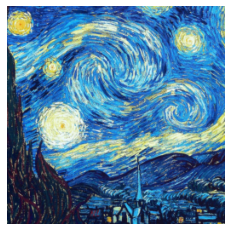

In [ ]:
# ======== DISPLAY / VISUALIZE DATASET =============

def plot_image(real_image, show=True):
    img = real_image.data.cpu().numpy()
    plt.axis('off')
    img = img.squeeze()
    img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
    #plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.show()

plot_image(style_image)

In [ ]:
from torch.nn.modules.conv import LazyConvTranspose1d
#Load VGG Model 

class ContentLoss(nn.Module):
  def __init__(self):
    super(ContentLoss, self).__init__()

  def forward(self, x, y): 
    loss = nn.MSELoss()(x, y)
    return loss

class StyleLayer(nn.Module): 
  def __init__(self, target): 
    super(StyleLayer, self).__init__() 
    self.target = target

  def gramMatrix(self, x):
    n, c, h, w = x.size()
    x_reshape = x.view(n * c, h * w)
    return x_reshape @ x_reshape.T / (n * c * h * w)

  def forward(self, x):
    n, c, h, w = x.size()
    target = self.target.repeat(n, 1, 1, 1)
    input_gram = self.gramMatrix(target)
    x_gram = self.gramMatrix(x)
    self.ftmap = x
    self.loss = torch.linalg.matrix_norm(input_gram - x_gram) ** 2
    return x

In [ ]:
FEATURE_LOSS = ['relu3_3']
STYLE_LOSS = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']

def vggNetwork(vgg16, style_layer, content_layer, style_target):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  style_target = style_target.to(device)
  vgg16 = vgg16.to(device)
  Style_Layer = []
  Content_Layer = []
  relu_count = 0
  block_count = 1
  name = 'dummy'
  model = nn.Sequential()
  for child in vgg16.children():
    if isinstance(child, nn.AdaptiveAvgPool2d):   #delete layers of the network after the last 
      break
    if isinstance(child, nn.Sequential):
      for i, layer in enumerate(child):
        model.add_module('layer_{}'.format(i), layer)
        if isinstance(layer, nn.ReLU):
          relu_count += 1
          string = 'relu{}_{}'.format(block_count, relu_count)
          if string in style_layer: 
            style_output = model(style_target).to(device)
            newLayer = StyleLayer(style_output).to(device)
            Style_Layer.append(newLayer)
            model.add_module('Style_Layer_{}'.format(i), newLayer)
            if string in content_layer:
              Content_Layer.append(newLayer)
        elif isinstance(layer, nn.MaxPool2d):
          block_count += 1
          relu_count = 0
  model.to(DEVICE)
  return model, Style_Layer, Content_Layer

In [ ]:
model, style, content = vggNetwork(vgg16, STYLE_LOSS, FEATURE_LOSS, style_image)

In [ ]:
## LOAD DATA HERE 

In [ ]:
def train(fx, vgg16, Loss, style_img, dataloader, content_fn, epochs = 5, tv_reg = True):
  #calculate the style-cost 
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  VGGmodel, style_layers, content_layers = vggNetwork(vgg16, STYLE_LOSS, FEATURE_LOSS, style_image)
  optimizer = torch.optim.Adam(fx.parameters(), lr = OPTIMIZER_LR)
  VGGmodel.requires_grad_(False)
  fx.requires_grad_(True)

  for epoch in range(epochs):
    totalContentLoss = 0 
    totalStyleLoss = 0
    totalLoss = 0
    
    for i, X in enumerate(dataloader):
      X = X.to(device)
      optimizer.zero_grad()

      ##get content loss 
      content_output = VGGmodel(X)
      content_map = content_layers[0].ftmap

      #pass through image in both 
      transformed_output = fx(X)
      transformed_loss_output = VGGmodel(transformed_output) 

      #calculate content loss
      content_transformed_map = content_layers[0].ftmap
      content_loss = content_fn(content_map, content_transformed_map)

      #calculate style map 
      style_loss = 0
      for map in style_layers:
        style_loss += map.loss 

      #calculate total variation regularization 
      tv_loss = 0
      if tv_reg:
        n, c, h_x, w_x = transformed_output.size()
        h_tv = torch.pow((transformed_output[:,:,1:,:]-transformed_output[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((transformed_output[:,:,:,1:]-transformed_output[:,:,:,:w_x-1]),2).sum()
        tv_loss = h_tv + w_tv 

      #calculate total Loss 
      loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss + TV_WEIGHT * tv_loss
      loss.backward()
      optimizer.step()

      totalContentLoss += content_loss.detach()
      totalStyleLoss += style_loss.detach()
      totalLoss += loss.detach()

      if i % 50 == 0:
        print(f'Total Loss for EPOCH {epoch}, training example {i} is {loss.detach()}')
    
    Loss['Content'].append(totalContentLoss)
    Loss['Style'].append(totalStyleLoss)
    Loss['Total'].append(totalLoss)
    
    print(f'EPOCH {epoch} COMPLETE')
  return fx, Loss

In [ ]:
fx = ImageTransformNet().train().to(DEVICE)
Loss = {}
Loss['Content'] = []
Loss['Style'] = []
Loss['Total'] = []

model, loss = train(fx, vgg16, Loss, style_image, dataloader, ContentLoss())